<a href="https://colab.research.google.com/github/kirbu123/FilmGeneration/blob/develop/FilmGenerationAttemp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import usefull libs

In [ ]:
!pip install setuptools-rust

In [ ]:
!pip install transformers==2.5.1

In [4]:
!pip install diffusers

In [5]:
!pip install img2dataset

In [6]:
!pip install wandb

In [20]:
import torch
import time
from datetime import datetime
from tqdm import tqdm
import pandas as pd
from google.colab import drive
import os
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, KFold
from sklearn.multiclass import OneVsRestClassifier
from PIL import Image
import requests
from io import BytesIO
from bs4 import BeautifulSoup
import pandas as pd
import csv
from urllib.request import urlopen
import multiprocessing
import wandb
import tarfile
import json

## Correct dataset loading by API

In [ ]:
# Making directory for url-list files
!mkdir -p laion-high-resolution && cd laion-high-resolution
# Downloading files from url
!for i in {00000..00001}; do wget -P laion-high-resolution/ https://huggingface.co/datasets/laion/laion-high-resolution/resolve/main/part-$i-5d6701c4-b238-4c0a-84e4-fe8e9daea963-c000.snappy.parquet; done

In [9]:
# Loginig in wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [10]:
#!rm -rf /content/laion-high-resolution-output

In [11]:
# Downloading .tar by url-list files from created directory
# Do not forget to stop running after completing the load
!img2dataset --url_list laion-high-resolution --input_format "parquet"\
         --url_col "URL" --caption_col "TEXT" --output_format webdataset\
           --output_folder laion-high-resolution-output --processes_count 16 --thread_count 64 --image_size 1024\
            --resize_only_if_bigger=True --resize_mode="keep_ratio" --skip_reencode=True \
             --save_additional_columns '["similarity","hash","punsafe","pwatermark","LANGUAGE"]' --enable_wandb True

Starting the downloading of this file
Sharding file number 1 of 2 called /content/laion-high-resolution/part-00000-5d6701c4-b238-4c0a-84e4-fe8e9daea963-c000.snappy.parquet
0it [00:00, ?it/s]File sharded in 137 shards
wandb: Currently logged in as: kirbucom (bunkir2004). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.15.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.12.21
wandb: Run data is saved locally in /content/wandb/run-20231003_100420-1s34th2s
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run drawn-sun-8
wandb: ⭐️ View project at https://wandb.ai/bunkir2004/img2dataset
wandb: 🚀 View run at https://wandb.ai/bunkir2004/img2dataset/runs/1s34th2s
0it [02:10, ?it/s]
/usr/lib/python3.10/multiprocessing/resource_tracker.py:224: UserWarning: resource_tracker: There appear to be 32 leaked semaphore objects to clean up at shutdown
  warnings.warn('resource_tracker: There appear t

In [12]:
# Creating dataset directory for ready files
!mkdir -p dataset

In [13]:
# Function encode .tar by the path
# Files will encode in /content/, do not forget to use next func
def UnboxTar(tar_path = "/content/laion-high-resolution-output/00000.tar"):
  try:
      tar = tarfile.open(tar_path)
      tar.extractall()
      tar.close()
  except Exception:
      print('Error')

In [14]:
UnboxTar()

Error


In [29]:
# Move all files from /content/ to file_path directory
def ReloadAllToFrom(file_path = 'dataset', directory = '/content/'):
  !mkdir -p {file_path}
  for filename in os.listdir(directory):
    # os.path.join соединяет путь до директории и имя файла
    path = os.path.join(directory, filename)
    # os.path.isfile проверяет, является ли путь файлом (а не папкой)
    if os.path.isfile(path):
      !mv {path} {file_path + '/' + path[path.rfind('/') + 2:]}

In [64]:
# Move image files from /content/ to file_path directory
def ReloadImgFromTo(from_path = 'dataset', to_path = 'dataset_images'):
  !mkdir -p {to_path}
  for filename in os.listdir(from_path):
    # os.path.join соединяет путь до директории и имя файла
    path = os.path.join(from_path, filename)
    # os.path.isfile проверяет, является ли путь файлом (а не папкой)

    if os.path.isfile(path):
      if path[path.find('.') + 1:] == 'jpg' or path[path.find('.') + 1:] == 'png' or path[path.find('.') + 1:] == 'jpeg':
        !mv {path} {to_path + '/' + path[path.rfind('/') + 2:]}

In [61]:
# Move all files from /content/ to file_path directory and add json
def ReloadAllToFromAddJson(file_path = 'dataset_cap_img', directory = '/content/dataset'):
  !mkdir -p {file_path}
  file_nums = list()
  for filename in os.listdir(directory):
    # os.path.join соединяет путь до директории и имя файла
    path = os.path.join(directory, filename)
    # os.path.isfile проверяет, является ли путь файлом (а не папкой)
    if os.path.isfile(path):
      if path[path.find('.') + 1:] == 'jpg' or path[path.find('.') + 1:] == 'png' or path[path.find('.') + 1:] == 'jpeg':
        !mv {path} {file_path + '/' + path[path.rfind('/') + 2:]}
        pass
      if path[path.find('.') + 1:] == 'txt':
        file_nums.append(path[:path.find('.')])
  result_list = list()
  for num in file_nums:
    elem = dict()
    elem['file_name'] = (num + '.jpg').split('/')[-1]
    with open(num + '.txt', 'r') as f:
      elem['text'] = f.readline()
    result_list.append(elem)
  json_file = open(file_path + "/metadata.jsonl", "w")
  for entry in result_list:
    json_entry = json.dumps(entry)
    json_file.write(json_entry + "\n")
  return result_list

In [62]:
mas = ReloadAllToFromAddJson()

In [36]:
data = [
    {"name": "John", "age": 25},
    {"name": "Jane", "age": 30},
    {"name": "Bob", "age": 35}
]

file = open("dataset.jsonl", "w")

for entry in data:
    json_entry = json.dumps(entry)
    file.write(json_entry + "\n")

file.close()

In [17]:
ReloadAllToFrom()

In [18]:
ReloadImgFromTo()

In [ ]:
!zip -r /content/dataset.zip /content/dataset

In [30]:
ReloadAllToFrom('/content/dataset', '/content/dataset_images')

As a result we have directory (named dataset in default situation) with text, images and describes from the dataset.

## Load dataset by parsing (bad alternative)

Make data directory, go there

In [ ]:
!mkdir laion-high-resolution && cd laion-high-resolution

In [ ]:
# Function for loading 100 rows of dataset from the url
# Param filtering indicate filtering of data by languages (langs) when it is filtering = True
# Param filter_lang sorts data from all langs except filter_lang
# Param file_name sets file_name + .csv
def LoadLaionDataset(filtering = False, filter_lang = '', load_csv = False, file_name = 'dataset', url = 'https://huggingface.co/datasets/laion/laion-high-resolution/viewer/default/train'):
  # Created an URL object in url
  # Create object page
  page = requests.get(url)
  # parser-lxml = Change html to Python friendly format
  # Obtain page's information
  soup = BeautifulSoup(page.text, 'lxml')
  # Obtain information from tag <table>
  table = soup.find('table', attrs={"class": "w-full table-auto rounded-lg font-mono text-xs text-gray-900"})
  # Obtain every title of columns with tag <th>
  headers = []
  for i in table.find_all('th'):
    title = i.text
    headers.append(title[:title.find('\n')])
  # Create a dataframe
  df = pd.DataFrame(columns = headers)
  # Create a for loop to fill mydata
  for j in table.find_all('tr')[1:]:
    row_data = j.find_all('td')
    row = [i.text[:i.text.find('\n')] for i in row_data]
    for i in range(len(row)):
      row[i] = row[i][row[i].find('"') + 1: row[i].rfind('"')]
    length = len(df)
    df.loc[length] = row
  # Filtering by languages
  if filtering:
    df = df[df['LANGUAGE'] == filter_lang]
  # Loading .csv
  if load_csv:
    df.to_csv ('/content/laion-high-resolution/' + str(file_name) + '.csv', index= False )
  return df

In [ ]:
df = LoadLaionDataset(load_csv = True)

AttributeError: ignored

In [ ]:
df.head()

Upgrade of dataset loading function

In [ ]:
# Param frames_count sets count of loading url pages
# Other params are same eith previous function
def LoadData(frames_count = 1, filtering = False, filter_lang = '', load_csv = False, file_name = 'dataset', based_url = 'https://huggingface.co/datasets/laion/laion-high-resolution/viewer/default/train'):
  # DataFrame list
  df_list = list()
  # Updating df_list by loading .csv by url
  for i in tqdm(range(frames_count)):
    df_list.append(LoadLaionDataset(filtering, filter_lang, load_csv = False, url = based_url + '?p=' + str(i)))
  # concating df_list to one big DataFrame
  result_df = pd.concat(df_list)
  X = result_df[['TEXT', 'LANGUAGE']].to_numpy()
  y = result_df['URL'].to_numpy()
  return result_df, list([X, y])

In [ ]:
df, dataset = LoadData(frames_count = 1)

100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


In [ ]:
len(df)

100

In [ ]:
df.head()

,URL,TEXT,WIDTH,HEIGHT,similarity,LANGUAGE,hash,pwatermark,punsafe
0,https://mmedia.ozone.ru/multimedia/1018085734.JP,"Штора рулонная Эскар, цвет: абрикосовый, ширин...","1,02","1,20",0.27589,r,"-3,448,109,611,037,364,00",0.05275,0.00129
1,https://images.squarespace-cdn.com/content/v1/...,Elysia Lounge chair from DeLaEspad,"2,50","1,66",0.29183,nolan,"1,517,529,356,012,770,30",0.05878,0.00001
2,https://images.footballfanatics.com/FFImage/th...,Houston Texans Striped Prime Time Backpac,"2,00","2,00",0.39709,e,"5,924,454,315,519,412,00",nul,nul
3,https://images.squarespace-cdn.com/content/v1/...,©Radiohead-Bandcam,"1,20","1,20",0.26665,nolan,"-3,933,968,474,534,865,40",0.06562,0.00001
4,"https://s3.r29static.com/bin/entry/4ce/0,0,200...",Amazon Registry Best Wedding Gift Item,"2,00","1,05",0.31002,e,"7,893,281,056,273,843,00",0.15549,0.00004


In [ ]:
dataset[0][0]

array(['Штора рулонная Эскар, цвет: абрикосовый, ширина 140 см, высота 170 см81012140170Рулонными шторами Эскар можно оформлять окна как самостоятельно, так и использовать в комбинации с портьерами. Это поможет предотвратить выгорание дорогой ткани на солнце и соединит функционал рулонных с красотой навесных. Преимущества применения рулонных штор для пластиковых окон: - имеют прекрасный внешний вид: многообразие и фактурность материала изделия отлично смотрятся в любом интерьере;- многофункциональны: есть возможность подобрать шторы способные эффективно защитить комнату от солнца, при этом она не будет слишком темной;- есть возможность осуществить быстрый монтаж.ВНИМАНИЕ! Размеры ширины изделия указаны по ширине ткани! Во время эксплуатации не рекомендуется полностью разматывать рулон, чтобы не оторвать ткань от намоточного вала. В случае загрязнения поверхности ткани, чистку шторы проводят одним из способов, в зависимости от типа загрязнения:легкое поверхностное загрязнение можно удал

## KFold sampling on train-test split



In [ ]:
# This func makes KFold from Sklearn more convinient to out task
def KFoldSampling(dataset, nsplits):
  # X, y split from dataset
  X, y = dataset[0], dataset[1]
  kf = KFold(n_splits = nsplits)
  kf.get_n_splits()
  # list of indicies of KFold
  result = list()
  for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    # Appending train-test indicies ro result list
    result.append(np.array([train_index, test_index]))
  return np.array(result)

In [ ]:
KFoldSampling(dataset, nsplits=2)

2it [00:00, 927.53it/s]


array([[[50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
         66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
         82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
         98, 99],
        [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
         32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49]],

       [[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
         32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49],
        [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
         66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81,
         82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97,
         98, 99]]])

## Dataset transform from url to image

In [ ]:
# Function for loading image
def LoadImageMulti(url, queue):
  response = requests.get(url)
  img = Image.open(BytesIO(response.content))
  queue.put(img)

# Safe loading of image with time limit

def LineStop(target, arg, time_limit = 10):
  queue = multiprocessing.Queue()
  p = multiprocessing.Process(target=target, args=(arg, queue))
  p.start()
  p.join(time_limit)
  if p.is_alive():
    print('ABORT')
    # Terminate
    p.terminate()
    return
  return queue.get()

LineStop(LoadImageMulti, 'https://mmedia.ozone.ru/multimedia/1018085734.JPG')

ABORT


In [ ]:
def DatasetTransform(dataset, image_dir = '', time_limit = 10, all_time_limit = 1000):
  # Making directory for dataset
  if image_dir:
    if image_dir[len(image_dir) - 1] == '/':
      image_dir = image_dir[:len(image_dir) - 1]
    os.environ["DIRECTORY_NAME"] = image_dir
    !mkdir -p ${DIRECTORY_NAME}
  # Making X, y from dataset
  X = dataset[0]
  y = dataset[1]
  # Making result lists
  result_y = list()
  result_X = list()
  # Start time
  start_time = datetime.now()

  for i, url in enumerate(tqdm(y)):
    # All exceptions are ignored
    try:
      # Load image
      response = requests.get(url)
      img = Image.open(BytesIO(response.content))
      if image_dir:
        print(image_dir + '/image_' + str(i) + '.jpg')
        img.save(image_dir + '/image_' + str(i) + '.jpg')
    except Exception:
      continue
    # Appending numpy image
    result_y.append(np.array(img))
    result_X.append(X[i])
    # Checking time break
    if (datetime.now() - start_time).seconds > all_time_limit:
      print('Time break')
      return list([np.array(result_X), np.array(result_y)])
  return list([np.array(result_X), np.array(result_y)])

In [ ]:
DatasetTransform(dataset, image_dir='/content/data_images', all_time_limit = 30)

  2%|▏         | 2/100 [00:01<00:56,  1.75it/s]

/content/data_images/image_1.jpg


  3%|▎         | 3/100 [00:11<07:43,  4.78s/it]

/content/data_images/image_2.jpg


  4%|▍         | 4/100 [00:11<04:51,  3.03s/it]

/content/data_images/image_3.jpg


  6%|▌         | 6/100 [00:12<02:22,  1.52s/it]

/content/data_images/image_5.jpg


  9%|▉         | 9/100 [00:14<01:32,  1.02s/it]

/content/data_images/image_8.jpg


 10%|█         | 10/100 [00:14<01:14,  1.22it/s]

/content/data_images/image_9.jpg


 12%|█▏        | 12/100 [00:16<01:00,  1.46it/s]

/content/data_images/image_11.jpg


 13%|█▎        | 13/100 [00:16<00:50,  1.73it/s]

/content/data_images/image_12.jpg


 16%|█▌        | 16/100 [00:20<01:34,  1.13s/it]

/content/data_images/image_15.jpg


 18%|█▊        | 18/100 [00:22<01:24,  1.03s/it]

/content/data_images/image_17.jpg


 23%|██▎       | 23/100 [00:35<04:34,  3.57s/it]<ipython-input-19-4fde11e43845>:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return list([np.array(result_X), np.array(result_y)])
 23%|██▎       | 23/100 [00:35<01:58,  1.54s/it]

/content/data_images/image_23.jpg
Time break


[array([['Elysia Lounge chair from DeLaEspad', 'nolan'],
        ['Houston Texans Striped Prime Time Backpac', 'e'],
        ['©Radiohead-Bandcam', 'nolan'],
        ['Gurneys Star Island Wedding Photo', 'nolan'],
        ['Masjid Fundraising Campaign Dinner – 11th May Updat', 'e'],
        ["Forbidden Island's menu..", 'nolan'],
        ['117 Evergreen, Kirkland, Illinois, 6014', 'f'],
        ['Students on the Walk of the Gods located on the Amalfi Coast (Photo: Canisius College',
         'e'],
        ['A4-Whitepaper-CitizenDevelopers-skill-ladder-', 'e'],
        ['Total War Warhammer Wallpaper Hd Artstation Centipede Mountain Chen Ziy',
         'nolan'],
        ['large scale helicopter prin', 'e']], dtype=object),
 array([array([[[238, 238, 238],
                [238, 238, 238],
                [238, 238, 238],
                ...,
                [238, 238, 238],
                [238, 238, 238],
                [238, 238, 238]],
 
               [[238, 238, 238],
             

## SDXL PART

## Loading packages

Downloading & Importing smth

In [ ]:
!pip install --upgrade safetensors

In [ ]:
!pip install transformers

In [ ]:
!pip install huggingface_hub

In [ ]:
!pip install diffusers

In [ ]:
from huggingface_hub import snapshot_download
from diffusers import DiffusionPipeline, StableDiffusionXLImg2ImgPipeline

## Refactoring directory by matching images

In [ ]:
def MatchImagesDir(directory = '/content/data_images', target_dir = '/content/matched_images'):
  !mkdir -p {target_dir}
  list_img = list()
  for filename in os.listdir(directory):
    # os.path.join соединяет путь до директории и имя файла
    path = os.path.join(directory, filename)
    # os.path.isfile проверяет, является ли путь файлом (а не папкой)

    if os.path.isfile(path):
      if path[path.find('.') + 1:] == 'jpg' or path[path.find('.') + 1:] == 'png' or path[path.find('.') + 1:] == 'jpeg':
        list_img.append(path)
  for i in range(len(list_img) - 1):
    # Read images
    img_left = Image.open(list_img[i])
    img_right = Image.open(list_img[i + 1])
    # Reading sizes
    width_left, height_left = img_left.size
    width_right, height_right = img_right.size
    # Counting new sizes
    result_width = width_left + width_right
    result_height = max(height_left, height_right)
    # Making result image
    result = Image.new('RGB', (result_width, result_height))
    # Refactoring result image
    result.paste(im=img_left, box=(0, 0))
    result.paste(im=img_right, box=(width_left, 0))
    # Save result image
    result.save(target_dir + '/matched' + str(i) + '.jpg')

In [ ]:
MatchImagesDir(directory='/content/dataset_images')

OSError: ignored

## SDXL with dreambooth Finetuning

Example pictures dataset

In [ ]:
local_dir = "./dog"
snapshot_download(
    "diffusers/dog-example",
    local_dir=local_dir, repo_type="dataset",
    ignore_patterns=".gitattributes",
)

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

'/content/dog'

In [ ]:
#@title 🤗 AutoTrain DreamBooth
#@markdown In order to use this colab
#@markdown - upload images to a folder named `images/`
#@markdown - choose a project name if you wish
#@markdown - change model if you wish, you can also select sd2/2.1 or sd1.5
#@markdown - update prompt and remember it. choose keywords that don't usually appear in dictionaries
#@markdown - add huggingface information (token and repo_id) if you wish to push trained model to huggingface hub
#@markdown - update hyperparameters if you wish
#@markdown - click `Runtime > Run all` or run each cell individually

!pip install -U autotrain-advanced > install_logs.txt
!autotrain setup > setup_logs.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
img2dataset 1.42.0 requires fsspec==2022.11.0, but you have fsspec 2023.6.0 which is incompatible.
tensorflow-metadata 1.14.0 requires protobuf<4.21,>=3.20.3, but you have protobuf 4.23.4 which is incompatible.
wandb 0.12.21 requires protobuf<4.0dev,>=3.12.0, but you have protobuf 4.23.4 which is incompatible.
> INFO    Installing latest transformers@main
> INFO    Successfully installed latest transformers
> INFO    Installing latest peft@main
> INFO    Successfully installed latest peft
> INFO    Installing latest diffusers@main
> INFO    Successfully installed latest diffusers
> INFO    Installing latest trl@main
> INFO    Successfully installed latest trl
> INFO    Installing latest xformers
> INFO    Successfully installed latest xformers


In [ ]:
#@markdown ---
#@markdown #### Project Config
project_name = 'fine_tuned_model' # @param {type:"string"}
dataset_dir = '/content/matched_images' # @param {type: "string"}
model_name = 'runwayml/stable-diffusion-v1-5' # @param ["stabilityai/stable-diffusion-xl-base-1.0", "runwayml/stable-diffusion-v1-5", "stabilityai/stable-diffusion-2-1", "stabilityai/stable-diffusion-2-1-base"]
prompt = 'GRID' # @param {type: "string"}


#@markdown ---
#@markdown #### Push to Hub?
#@markdown Use these only if you want to push your trained model to a private repo in your Hugging Face Account
#@markdown If you dont use these, the model will be saved in Google Colab and you are required to download it manually.
#@markdown Please enter your Hugging Face write token. The trained model will be saved to your Hugging Face account.
#@markdown You can find your token here: https://huggingface.co/settings/tokens
push_to_hub = False # @param ["False", "True"] {type:"raw"}
hf_token = "hf_XXX" #@param {type:"string"}
repo_id = "username/repo_name" #@param {type:"string"}

#@markdown ---
#@markdown #### Hyperparameters
learning_rate = 1e-4 # @param {type:"number"}
num_steps = 200 #@param {type:"number"}
batch_size = 1 # @param {type:"slider", min:1, max:32, step:1}
gradient_accumulation = 4 # @param {type:"slider", min:1, max:32, step:1}
resolution = 1024 # @param {type:"slider", min:128, max:1024, step:128}
use_8bit_adam = True # @param ["False", "True"] {type:"raw"}
use_xformers = True # @param ["False", "True"] {type:"raw"}
use_fp16 = True # @param ["False", "True"] {type:"raw"}
train_text_encoder = False # @param ["False", "True"] {type:"raw"}
gradient_checkpointing = True # @param ["False", "True"] {type:"raw"}

os.environ["PROJECT_NAME"] = project_name
os.environ["DATASET_DIR"] = dataset_dir
os.environ["MODEL_NAME"] = model_name
os.environ["PROMPT"] = prompt
os.environ["PUSH_TO_HUB"] = str(push_to_hub)
os.environ["HF_TOKEN"] = hf_token
os.environ["REPO_ID"] = repo_id
os.environ["LEARNING_RATE"] = str(learning_rate)
os.environ["NUM_STEPS"] = str(num_steps)
os.environ["BATCH_SIZE"] = str(batch_size)
os.environ["GRADIENT_ACCUMULATION"] = str(gradient_accumulation)
os.environ["RESOLUTION"] = str(resolution)
os.environ["USE_8BIT_ADAM"] = str(use_8bit_adam)
os.environ["USE_XFORMERS"] = str(use_xformers)
os.environ["USE_FP16"] = str(use_fp16)
os.environ["TRAIN_TEXT_ENCODER"] = str(train_text_encoder)
os.environ["GRADIENT_CHECKPOINTING"] = str(gradient_checkpointing)

Fine tune and getting weights

In [ ]:
!autotrain dreambooth \
--model ${MODEL_NAME} \
--project-name ${PROJECT_NAME} \
--image-path ${DATASET_DIR} \
--prompt "${PROMPT}" \
--resolution ${RESOLUTION} \
--batch-size ${BATCH_SIZE} \
--num-steps ${NUM_STEPS} \
--gradient-accumulation ${GRADIENT_ACCUMULATION} \
--lr ${LEARNING_RATE} \
$( [[ "$USE_FP16" == "True" ]] && echo "--fp16" ) \
$( [[ "$USE_XFORMERS" == "True" ]] && echo "--xformers" ) \
$( [[ "$TRAIN_TEXT_ENCODER" == "True" ]] && echo "--train-text-encoder" ) \
$( [[ "$USE_8BIT_ADAM" == "True" ]] && echo "--use-8bit-adam" ) \
$( [[ "$GRADIENT_CHECKPOINTING" == "True" ]] && echo "--gradient-checkpointing" ) \
$( [[ "$PUSH_TO_HUB" == "True" ]] && echo "--push-to-hub --token ${HF_TOKEN} --repo-id ${REPO_ID}" )

In [ ]:
# Function for getting image from prompt
def ImageFromPrompt(prompt, weight_name="pytorch_lora_weights.safetensors", project_name=project_name, model=model_name):
  prj_path = "/content/" + str(project_name)
  pipe = DiffusionPipeline.from_pretrained(
      model,
      torch_dtype=torch.float16,
  )
  pipe.to("cuda")
  pipe.load_lora_weights(prj_path, weight_name=weight_name)

  refiner = StableDiffusionXLImg2ImgPipeline.from_pretrained(
      "stabilityai/stable-diffusion-xl-refiner-1.0",
      torch_dtype=torch.float16,
  )
  refiner.to("cuda")

  seed = 42
  generator = torch.Generator("cuda").manual_seed(seed)
  image = pipe(prompt=prompt, generator=generator).images[0]
  image_upgrade = refiner(prompt=prompt, generator=generator, image=image).images[0]
  return image, image_upgrade

In [ ]:
img, img_upgrade = ImageFromPrompt('GRID | photo of Leo Messi | photo of Cristiano Ronaldo')

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Loading the tokenizer from the `special_tokens_map.json` and the `added_tokens.json` will be removed in `transformers 5`,  it is kept for forward compatibility, but it is recommended to update your `tokenizer_config.json` by uploading it again. You will see the new `added_tokens_decoder` attribute that will store the relevant information.


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

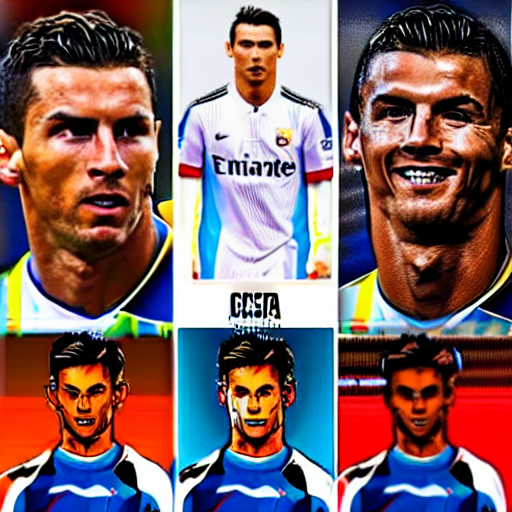

In [ ]:
img

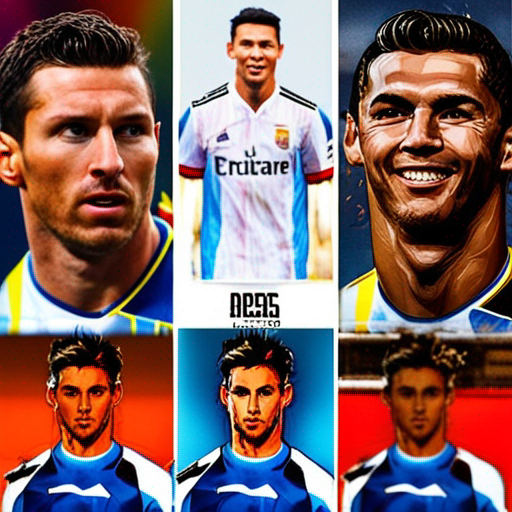

In [ ]:
img_upgrade

## SDXL with text2image Finetuning

Cloning diffusers repository

In [1]:
!git clone https://github.com/huggingface/diffusers.git

Cloning into 'diffusers'...
remote: Enumerating objects: 38571, done.
remote: Counting objects: 100% (655/655), done.
remote: Compressing objects: 100% (358/358), done.
remote: Total 38571 (delta 398), reused 431 (delta 250), pack-reused 37916
Receiving objects: 100% (38571/38571), 25.75 MiB | 19.49 MiB/s, done.
Resolving deltas: 100% (28463/28463), done.


# !!! CREATORS OF DIFFUSERS ARE STUPIT, DO NOT FORGET IT !!!

# CHANGE  /content/diffusers/examples/text_to_image/train_text_to_image_lora.py to train_text_to_image_lora.py from https://github.com/kirbu123/FilmGeneration/blob/develop/train_text_to_image_lora.py


In [2]:
!pip install -U -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
!pip install wandb

In [5]:
#import wandb

In [6]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
!pip install accelerate

In [8]:
!pip install transformers

In [9]:
!pip install --upgrade diffusers

In [ ]:
!pip install datasets

In [14]:
#@markdown ---
#@markdown #### Project Config
output_dir = 'fine_tuned_model' # @param {type:"string"}
data_dir = '/content/dataset' # @param {type: "string"}
model_name = 'runwayml/stable-diffusion-v1-5' # @param ["stabilityai/stable-diffusion-xl-base-1.0", "runwayml/stable-diffusion-v1-5", "stabilityai/stable-diffusion-2-1", "stabilityai/stable-diffusion-2-1-base"]

#@markdown ---
#@markdown #### Hyperparameters
mixed_precision="fp16" # @param {type: "string"}
learning_rate = 3e-4 # @param {type:"number"}
resolution = 1024 # @param {type:"slider", min:128, max:1024, step:128}
batch_size = 1 # @param {type:"slider", min:1, max:32, step:1}
gradient_accumulation = 4 # @param {type:"slider", min:1, max:32, step:1}
max_train_steps = 15 # @param {type:"number"}
max_grad_norm = 1 # @param {type:"number"}
checkpointing_steps = 10 # @param {type:"number"}
validation_prompt="A photo of a cat in a bucket" # @param {type: "string"}
validation_epochs=10 # @param {type:"number"}
seed=42 # @param {type:"number"}
report_to='wandb' # @param {type: "string"}

os.environ["SEED"] = str(seed)
os.environ["VAL_EPOCHS"] = str(validation_epochs)
os.environ["OUTPUT_DIR"] = output_dir
os.environ["DATA_DIR"] = data_dir
os.environ["MODEL_NAME"] = model_name
os.environ["MIXED_PRECISION"] = mixed_precision
os.environ["LEARNING_RATE"] = str(learning_rate)
os.environ["RESOLUTION"] = str(resolution)
os.environ["BATCH_SIZE"] = str(batch_size)
os.environ["GRADIENT_ACCUMULATION"] = str(gradient_accumulation)
os.environ["MAX_TRAIN_STEPS"] = str(max_train_steps)
os.environ["MAX_GRAD_NORM"] = str(max_grad_norm)
os.environ["CHECK_STEPS"] = str(checkpointing_steps)
os.environ["VAL_PROMPT"] = validation_prompt
os.environ["REPORT_TO"] = report_to

In [21]:
!accelerate launch --mixed_precision="fp16"  /content/diffusers/examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path="runwayml/stable-diffusion-v1-5" \
  --train_data_dir="/content/dataset" \
  --dataloader_num_workers=8 \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=15 \
  --learning_rate=3e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" --lr_warmup_steps=0 \
  --output_dir="models" \
  --checkpointing_steps=10 \
  --validation_prompt="A photo of a cat in a bucket" \
  --validation_epochs=10 \
  --seed=42 \
  --report_to=wandb

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2023-10-03 03:49:54.847802: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
10/03/2023 03:49:57 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'dynamic_thresholding_ratio', 'thresholding', 'clip_sample_range', 'prediction_type', 'timestep_spacing', 'sample_max_value', 'variance_type'} was not found in config. Values will be initialized to default values.
{'scaling_factor', 'force_upcast'} was not found in config. Values will be initialized to default values.
{'num_class_embeds', 'conv_out_kernel', 'addition_embed

In [ ]:
!accelerate launch --mixed_precision=${MIXED_PRECISION}  /content/diffusers/examples/text_to_image/train_text_to_image_lora.py \
  --pretrained_model_name_or_path=${MODEL_NAME} \
  --train_data_dir=${DATA_DIR} \
  --dataloader_num_workers=8 \
  --resolution=${RESOLUTION} --center_crop --random_flip \
  --train_batch_size=${BATCH_SIZE} \
  --gradient_accumulation_steps=${GRADIENT_ACCUMULATION} \
  --max_train_steps=${MAX_TRAIN_STEPS} \
  --learning_rate=${LEARNING_RATE} \
  --max_grad_norm=${MAX_GRAD_NORM} \
  --lr_scheduler="cosine" --lr_warmup_steps=0 \
  --output_dir=${OUTPUT_DIR} \
  --checkpointing_steps=${CHECK_STEPS} \
  --validation_prompt=${VAL_PROMPT} \
  --validation_epochs=${VAL_EPOCHS} \
  --seed=${SEED} \
  --report_to=wandb